# Image Colorization as pre-training task

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score,confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import time
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Creating the dataset

In [5]:
class CIFAR10Dataset(Dataset):
    def __init__(self, split='train', transform=None):
        if split == 'train':
            cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
        elif split == 'test':
            cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
        
        self.data = []
        self.labels = []
        self.transform = transform
        
        for i, (img, label) in enumerate(cifar_dataset):
            img_gray = rgb2gray(np.array(img)) # convert to lightness channel
            self.data.append(img_gray)
            self.labels.append(label)
            
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
       
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]


        if self.transform:
            img = self.transform(img)
        
        return img, label
    

In [6]:
train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # isto depois da erro no type dos dados, ver pq e corrigir
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = CIFAR10Dataset(split='train', transform=train_transform)

testset = CIFAR10Dataset(split='test', transform=test_transform)


batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size)

testloader = DataLoader(testset, batch_size=batch_size)



Files already downloaded and verified
Files already downloaded and verified


In [7]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)
label_size = tuple(label.shape)

print(image_size)
print(label, "->" ,label_size)

(1, 32, 32)
tensor(3, dtype=torch.int32) -> ()


### Preparing the Model

In [14]:
def initialize_parameters_random(layer):
        for module in layer.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                init.kaiming_normal_(module.weight)  # Randomly initialize weights
                if module.bias is not None:
                    init.constant_(module.bias, 0)  # Initialize biases to zeros

class ClassificationNet(nn.Module):             
    def __init__(self,random_initialization):
        super(ClassificationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 2048
        num_classes = 10

        ## First half: ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        ## Second half: Classification
        
        self.classifier = nn.Sequential(
                nn.Linear(MIDLEVEL_FEATURE_SIZE, MIDLEVEL_FEATURE_SIZE // 4),
                # add intermediate layer
                nn.ReLU(),
                nn.Linear(MIDLEVEL_FEATURE_SIZE // 4, num_classes),
                nn.Softmax(dim=1)
            )
        
        if random_initialization:
            initialize_parameters_random(self.classifier)
            initialize_parameters_random(self.midlevel_resnet)
        else:
            # initialize the weights of the classifier
            initialize_parameters_random(self.classifier)
            

    def forward(self, input):
        # Pass input through the encoder (modified ResNet)
        features = self.midlevel_resnet(input)
        features = features.view(features.size(0), -1)  # Flatten the features
        
        # Pass the flattened features through the classifier
        output = self.classifier(features)
        
        return output  


## Initialize the weights randomly

In [ ]:
model_random_init = ClassificationNet(random_initialization=True)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_random_init.parameters(), lr=0.001)

model_random_init.to(device)

## Defining the training loop

In [16]:


def train_model(model, trainloader, testloader, num_epochs=20):
    start=time.time()
    losses = []
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).long()  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 
            # convert y_batch to one hot encoding
            y_batch = F.one_hot(y_batch, num_classes=10)

            y_pred = model(x_batch)
      
            loss = criterion(y_pred.float(), y_batch.float())

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 75 batches 
            if not i % 75:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item()}')

        

        model.eval()  # Put the network in eval mode
        f1_score_epoch = 0
        accuracy_epoch = 0
        recall_epoch = 0
        precision_epoch = 0

        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).long()  
            # convert y_batch to one hot encoding
        
            y_batch = F.one_hot(y_batch, num_classes=10)
            y_pred = model(x_batch)

            loss = criterion(y_pred.float(), y_batch.float())

            # Convert y_batch and y_pred to their respective classes
            y_batch = torch.argmax(y_batch, dim=1)
            y_pred = torch.argmax(y_pred, dim=1)

            f1 = f1_score(y_batch.cpu(), y_pred.cpu(), average='weighted', zero_division=0)
            accuracy = accuracy_score(y_batch.cpu(), y_pred.cpu())
            recall = recall_score(y_batch.cpu(), y_pred.cpu(), average='weighted', zero_division=0)
            precision = precision_score(y_batch.cpu(), y_pred.cpu(), average='weighted', zero_division=0)

            f1_score_epoch += f1
            accuracy_epoch += accuracy
            recall_epoch += recall
            precision_epoch += precision

            # Do something with the calculated scores
            
        # Example: Print the scores for each 
        f1_score_epoch = f1_score_epoch / len(testloader)
        accuracy_epoch = accuracy_epoch / len(testloader)
        recall_epoch = recall_epoch / len(testloader)
        precision_epoch = precision_epoch / len(testloader)

        print(f"Epoch {epoch+1}: F1 Score: {f1_score_epoch:.4f}, Accuracy: {accuracy_epoch:.4f}, Recall: {recall_epoch:.4f}, Precision: {precision_epoch:.4f}")
        

        print(f'loss: {loss.item()}')
        losses.append(loss.item())

    return losses

## Training with random parameters


In [ ]:
losses_random_init = train_model(model_random_init, trainloader, testloader, num_epochs=25)

### Extract metrics from the testset (randomized parameters)

In [29]:
def extract_metrics(model, testloader, losses):
    model.eval()  # Put the network in eval mode
 
    y_pred_list = []
    y_batch_list = []

    for i, (x_batch, y_batch) in enumerate(testloader):
        x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).long()  
        # convert y_batch to one hot encoding

        y_batch = F.one_hot(y_batch, num_classes=10)
        y_pred = model(x_batch)

        loss = criterion(y_pred.float(), y_batch.float())

        # Convert y_batch and y_pred to their respective classes
        y_batch = torch.argmax(y_batch, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)

        y_pred_list.append(y_pred.cpu())
        y_batch_list.append(y_batch.cpu())

    y_pred_list = torch.cat(y_pred_list, dim=0)
    y_batch_list = torch.cat(y_batch_list, dim=0)
    # confusion matrix
    print("accuracy: ", accuracy_score(y_batch_list, y_pred_list))
    print("f1 score: ", f1_score(y_batch_list, y_pred_list, average='weighted'))
    print("recall: ", recall_score(y_batch_list, y_pred_list, average='weighted'))
    print("precision: ", precision_score(y_batch_list, y_pred_list, average='weighted'))
    print(confusion_matrix(y_batch_list, y_pred_list))

    #plot loss vs epoch graph
    #plt.plot(losses)
    #plt.title('loss vs epochs')
    #plt.xlabel('epochs')
    #plt.ylabel('loss')



In [ ]:
extract_metrics(model_random_init, testloader, losses_random_init)

## Training model with loaded weights

In [20]:
# function for loaduing weights of a trained model
def load_weights(weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    # get the latest file in the directory
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    # first model needs to be loaded
    model = ClassificationNet(random_initialization=False).to(device)

    # fixes odd error when state_dict has prescript "model."" in keys
    state_dict = torch.load(os.path.join(weights_dir, final_weight_file), map_location=device)
    for key in list(state_dict.keys()):
        if key.startswith("model."):
            state_dict[key[6:]] = state_dict.pop(key)
     
    model.load_state_dict(state_dict, strict=False)
    
    print('Loaded weights: ' + final_weight_file)
    
    return model

In [24]:
model_loaded_weights = load_weights('weights')
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_loaded_weights.parameters(), lr=0.001)



Loaded weights: epoch-40_accuracy-0.0.pth


## Train the image colorization model and extract metrics

In [ ]:
losses_loaded_weights = train_model(model_loaded_weights, trainloader, testloader, num_epochs=25)

In [ ]:
extract_metrics(model_loaded_weights, testloader, losses_loaded_weights)

## Data Visualization

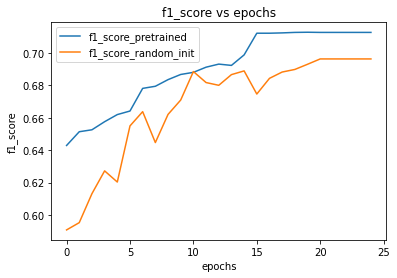

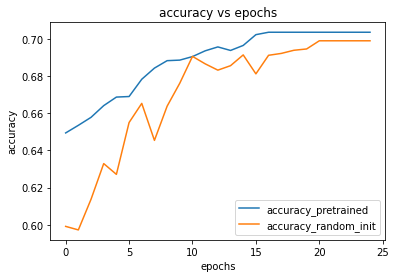

In [39]:

# list of metrics for each epoch for the pretrained model
f1_scores_pretrained = [0.6429, 0.6514, 0.6526, 0.6576, 0.6620, 0.6642, 0.6782, 0.6795, 0.6836, 0.6868, 0.6881, 0.6913, 0.6932, 0.6924, 0.6989, 0.7123, 0.7123, 0.7125, 0.7128, 0.7129, 0.7128, 0.7128,0.7128,0.7128,0.7128]
accuracy_pretrained = [0.6494, 0.6535, 0.6578, 0.6641, 0.6687, 0.6690, 0.6783, 0.6843, 0.6883,
                        0.6886, 0.6905, 0.6936, 0.6957, 0.6938, 0.6965, 0.7023, 0.7036, 0.7036, 0.7036, 0.7036, 0.7036, 0.7036,  0.7036,0.7036,0.7036]

# list of metrics for each epoch for the random initialization model

f1_scores_random_init = [0.5907, 0.5952, 0.6131, 0.6272, 0.6203, 0.6550, 0.6638, 0.6447, 0.6621, 0.6710, 0.6886, 0.6818, 0.6801, 0.6867, 0.6890, 0.6747, 0.6844, 0.6883, 0.6899, 0.6931, 0.6964, 0.6964,0.6964,0.6964,0.6964]
accuracy_random_init = [0.5991, 0.5972, 0.6137, 0.6329, 0.6271, 0.6550, 0.6653,
                         0.6454, 0.6638, 0.6762, 0.6906, 0.6866, 0.6832, 0.6856, 0.6914, 0.6812, 0.6912, 0.6922, 0.6939, 0.6946,0.6990,0.6990,0.6990,0.6990, 0.6990]


# draw graph of f1_score, accuracy, recall and precision vs epoch

plt.plot(f1_scores_pretrained, label='f1_score_pretrained')
plt.plot(f1_scores_random_init, label='f1_score_random_init')
plt.title('f1_score vs epochs')
plt.xlabel('epochs')
plt.ylabel('f1_score')
plt.legend()
plt.show()


plt.plot(accuracy_pretrained, label='accuracy_pretrained')
plt.plot(accuracy_random_init, label='accuracy_random_init')
plt.title('accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


